In [1]:
# Import Required Libararies

import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
plt.style.use('fivethirtyeight')

## 1: Data gathering and Analysis

For the purpose of obtaining the data, we can use `Yahoo` as our data source. Let's get the data for the Apple Stock `AAPL` for 10 years (April 18, 2011 - April 18, 2020). We will use `pandas_datareader` to obtain the data with the disccussed specs.

In [2]:
# Get the data for S&P500 for 10 Years
raw_df = pdr.DataReader('AAPL', data_source='yahoo', start='2011-04-18', end='2021-04-18')

We see that we have obtained a total of `2,516` datapoints that have 6 features like `High`, `Low` and etc. Notice how the date is up till 16th. That is because 17, 18 is Saturday and Sunday and no data is recorded for these 22 days.

In [3]:
# Show the head of the data
raw_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2011-04-18,11.865357,11.434286,11.646429,11.851786,609898800.0,10.208694
2011-04-19,12.070714,11.846786,11.896429,12.066429,419378400.0,10.393581
2011-04-20,12.348214,12.196429,12.268214,12.228929,700666400.0,10.533554
2011-04-21,12.683214,12.447143,12.678571,12.525000,753810400.0,10.788577
2011-04-25,12.633929,12.510714,12.512143,12.607500,266546000.0,10.859639
...,...,...,...,...,...,...
2021-04-12,132.850006,130.630005,132.520004,131.240005,91420000.0,131.240005
2021-04-13,134.660004,131.929993,132.440002,134.429993,91266500.0,134.429993
2021-04-14,135.000000,131.660004,134.940002,132.029999,87222800.0,132.029999


We can also do some statistical analysis that gives us an idea about the distribution of the data like `mean`, `standard-deviation` and the `percentiles`.

In [4]:
# Some Statistical analysis
raw_df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03,2516.000000
mean,39.972993,39.134884,39.558157,39.569388,2.442051e+08,37.868910
std,28.949612,28.150609,28.572168,28.567736,1.930939e+08,29.173653
min,11.346429,11.089286,11.310000,11.261429,4.544800e+07,9.700181
25%,20.905357,20.422501,20.636607,20.671786,1.112856e+08,17.989075
50%,29.347500,28.875000,29.111250,29.071250,1.748130e+08,27.018014
75%,47.117501,46.434374,46.704374,46.758126,3.140806e+08,45.500306
max,145.089996,141.369995,143.600006,143.160004,1.506120e+09,142.946396


We are interested in the prediction of the `Closing` price of the stock so let's plot the `Close` feaature.

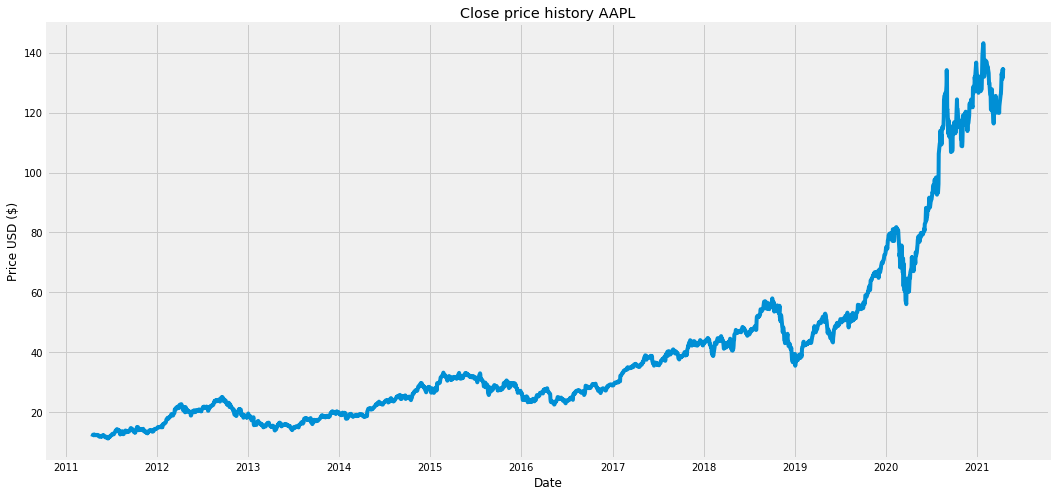

In [5]:
# Plot the Closing Price for the Stock
plt.figure(figsize=(16, 8))
plt.title('Close price history AAPL')
plt.plot(raw_df['Close'])
plt.xlabel('Date')
plt.ylabel('Price USD ($)')
plt.show()

## 2: Data Preprocessing 

We need some sort of windowing method that can generate features and targets from a univariate variable `Close`. We want to observe `some number of days` and based on the observation we want to predict the price for the next day. So we create a function `process_data` that takes in `data` and `number_of_days` as parameters and generates the features and target based on the `number_of_days` provided. 

So given an array of 6 numbers i.e `[1, 2, 3, 4, 5, 6]` and a `look_back` of 2, we can generate data like

| Pairs | Target |
| -: | -: |
| 1, 2 | 3 |
| 2, 3 | 4 |
| 3, 4 | 5 |
| 4, 5 | 6 |


In [6]:
# Method to create dataset for LSTM
def process_data(data, number_of_days=1):

  # Processed Dataholders
  datapoints, targets = [], []

  for i in range(number_of_days, len(data)):

    # Get chunks based on the `number_of_days`
    chunk = data[i - number_of_days: i, 0]

    # Get target against the generated chunk
    target = data[i, 0]
    
    # Append the chunk and target to corresponding holders
    datapoints.append(chunk)
    targets.append(target)
  
  # Cast to numpy and return
  return (np.array(datapoints), np.array(targets))

Let's Get the `Close` feature from the dataframe and also cast to `numpy` array

In [7]:
# Get the `Close` feature and convert to numpy array
close_price_df = raw_df.filter(['Close'])
data = close_price_df.values

Scaaling of the data is required so we can use `MinMaxScaler` that will scale our values in the range between (0 - 1)

In [8]:
# Scale the data using MinMaxScaler
scaler_object = MinMaxScaler(feature_range=(0, 1))
data = scaler_object.fit_transform(data)

We will observe past 90 days of data to make a prediction. We have to split our data set into training and testing sets with a ratio of 80-20 where 80 for training and 20 for testing. Once that's done, we can then use our `process_data` method to generate the features and target based on number of days for both training and testing sets.

In [9]:
# Generate train test data for model using 90 days (3 months)
number_of_days = 90

# Make Train-Test Split
training_data_amount = math.ceil(len(data) * .8)
train = data[0: training_data_amount, :]
test = data[training_data_amount - number_of_days: , :]

train_X, train_y = process_data(train, number_of_days)
test_X, test_y = process_data(test, number_of_days)

print(f"Shape of Training Data: {train_X.shape}")
print(f"Shape of Training Labels: {train_y.shape}")
print(f"Shape of Test Data: {test_X.shape}")
print(f"Shape of Test Labels: {test_y.shape}")

Shape of Training Data: (1923, 90)
Shape of Training Labels: (1923,)
Shape of Test Data: (503, 90)
Shape of Test Labels: (503,)


LSTMs require the data to be in a `Rank 3 Tensor` that can be described as `(number_of_samples, timesteps, number_of_features)`. For the `features` part we only have 1 as we are only observing the `Close` price so we can reshape the data to be a `Rank 3 Tensor`

In [10]:
# Reshape the data like (samples, timesteps, features)
train_X = np.reshape(train_X, newshape=(train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, newshape=(test_X.shape[0], test_X.shape[1], 1))

print(f"Training Data after reshaping: {train_X.shape}")
print(f"Testing Data after reshaping: {test_X.shape}")

Training Data after reshaping: (1923, 90, 1)
Testing Data after reshaping: (503, 90, 1)


## 3: Model Creation and Training

We will create a `Sequential` model that will use 2 stacked `LSTM` layers with `50 neurons` each, then we will have a `fully connected Dense layer` with 25 neurons and a `fully connected dense layer` with one neuron as `output layer`. We will compile the model with `adam` optimizer and `mean_squared_error` loss.

In [11]:
# Method to Generate a Sequential LSTM Model
def get_LSTM_Model(input_shape):

  # Sequential Model
  model = Sequential()

  # Stacked LSTM Laayers
  model.add(LSTM(50,return_sequences=True,input_shape=input_shape))
  model.add(LSTM(50,return_sequences=False))

  # Dense Layer
  model.add(Dense(25))

  # Output Layer
  model.add(Dense(1))

  # Compile the Model
  model.compile(
      optimizer='adam',
      loss='mean_squared_error',
  )

  # Print the model Summary
  print(model.summary())

  # Return the model
  return model

In [12]:
# Get LSTM Model
stackedLSTM = get_LSTM_Model(train_X.shape[1:])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 90, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 25)                1275      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________
None


Now let's train the model for 100 epochs with a batch size of 64

In [13]:
# Train the model
history = stackedLSTM.fit(
    x=train_X,
    y=train_y,
    validation_data=(test_X, test_y),
    batch_size=64,
    epochs=100,
    use_multiprocessing=True
)

Epoch 1/100
31/31 [==============================] - 6s 42ms/step - loss: 0.0082 - val_loss: 0.0012
Epoch 2/100
31/31 [==============================] - 0s 10ms/step - loss: 1.8751e-04 - val_loss: 0.0012
Epoch 3/100
31/31 [==============================] - 0s 11ms/step - loss: 7.5099e-05 - val_loss: 0.0012
Epoch 4/100
31/31 [==============================] - 0s 10ms/step - loss: 7.7788e-05 - val_loss: 0.0011
Epoch 5/100
31/31 [==============================] - 0s 10ms/step - loss: 7.7322e-05 - val_loss: 0.0010
Epoch 6/100
31/31 [==============================] - 0s 11ms/step - loss: 6.7219e-05 - val_loss: 0.0011
Epoch 7/100
31/31 [==============================] - 0s 10ms/step - loss: 7.1080e-05 - val_loss: 0.0012
Epoch 8/100
31/31 [==============================] - 0s 10ms/step - loss: 6.9300e-05 - val_loss: 0.0010
Epoch 9/100
31/31 [==============================] - 0s 10ms/step - loss: 7.2420e-05 - val_loss: 0.0015
Epoch 10/100
31/31 [==============================] - 0s 11ms/step -

## 4: Evaluation and Validation

Let's make predictions on our test data using the trained model.

In [14]:
# Make Predictions
predictions = stackedLSTM.predict(test_X)

Once the predictions are made, we have to inverse scale them to get back to the orignal scale.

In [15]:
# Reverse Scale the Values
predictions = scaler_object.inverse_transform(predictions)

The `RMSE` will tell us about the overall performance of the model. The lower the RMSE, the better our model will be.

In [16]:
# Get Root Mean Square Error (RMSE)
rmse = np.sqrt(np.mean(predictions - test_y) ** 2)
print(f"Root Mean Square Error (RMSE): {rmse}")

Root Mean Square Error (RMSE): 83.21052467186236


Now just simply plot the `ground_truth`, `validation_data` and the `predictions`.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


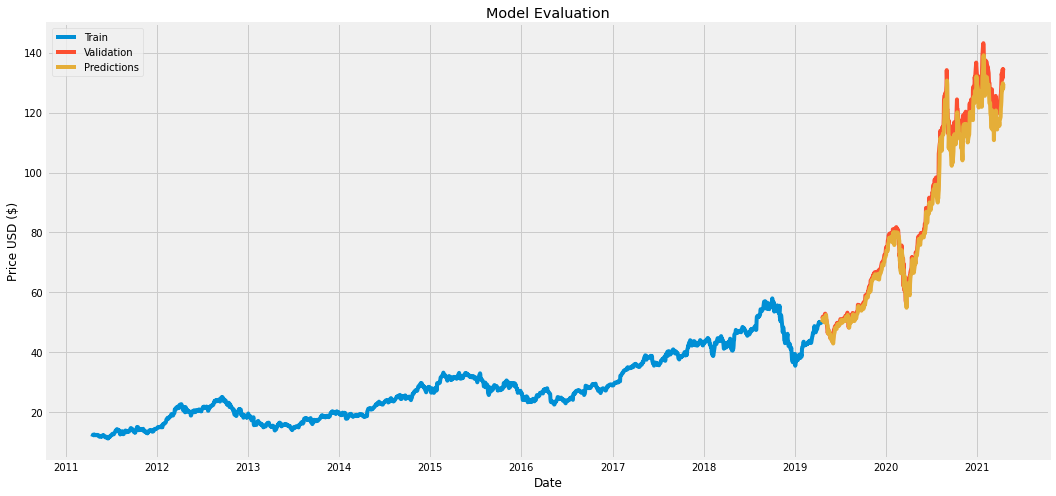

In [17]:
# Plot the data
ground_truth = close_price_df[: training_data_amount]
validation_data = close_price_df[training_data_amount: ]
validation_data['Predictions'] = predictions
plt.figure(figsize=(16, 8))
plt.title('Model Evaluation')
plt.xlabel('Date')
plt.ylabel('Price USD ($)')
plt.plot(ground_truth['Close'])
plt.plot(validation_data[['Close', 'Predictions']])
plt.legend(['Train', 'Validation', 'Predictions'], loc='best')
plt.show()

## 5: Make Future Prediction

Now we caan use the last past 90 days data to make a prediction for the future day like `April 19, 2020`

In [18]:
# Get last 90 days
last_90_days = close_price_df[-90: ].values

# Scale the data
scaled_data = scaler_object.transform(last_90_days)

# Reshape the data to Rank 3 Tensor
input_tensor = np.reshape(scaled_data, (scaled_data.shape[1], scaled_data.shape[0], 1))

# Make Prediction
predicted_price = stackedLSTM.predict(input_tensor)

# Inverse the scaling
predicted_price = scaler_object.inverse_transform(predicted_price)

# Print the price
print(f"I think the closing price for tomorrow will be: {predicted_price}")

I think the closing price for tomorrow will be: [[129.69821]]
